### Подключение к базе и основные таблицы

In [1]:
import pandas as pd

### Данные по пользователям

user_info = pd.read_sql(
    """SELECT * FROM public.user_data""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

user_info.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [2]:
### Посты и топики

posts_info = pd.read_sql(
    """SELECT * FROM public.post_text_df""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

posts_info.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [3]:
### Почти 77 миллионов записей, многовато!
### Не в каждую оперативу влезет столько данных
### Для обучения моделей

count_feed_data = pd.read_sql(
    """SELECT count(*) FROM public.feed_data""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

count_feed_data.head()

,count
0,76892800


In [4]:
### Попробуем забрать, скажем, 10 миллионов

feed_data = pd.read_sql(
    """SELECT * FROM public.feed_data LIMIT 10000000""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-10-16 22:46:31,11600,1174,view,0
1,2021-10-16 22:47:23,11600,6527,view,0
2,2021-10-16 22:48:15,11600,2011,view,0
3,2021-10-16 22:50:48,11600,308,view,0
4,2021-10-16 22:51:11,11600,5324,view,0


### Работа с данными и фичи для контентной модели

In [5]:
### Как устроена колонка target?

feed_data[feed_data.action!='view']

,timestamp,user_id,post_id,action,target
37,2021-11-08 18:35:33,11600,2872,like,0
42,2021-11-08 18:40:54,11600,2567,like,0
52,2021-11-08 18:55:22,11600,3833,like,0
72,2021-11-26 07:56:01,11600,4468,like,0
75,2021-11-26 08:00:33,11600,1442,like,0
...,...,...,...,...,...
9999946,2021-10-16 07:34:40,113976,3595,like,0
9999959,2021-10-17 22:51:45,113976,1644,like,0
9999963,2021-10-17 22:58:03,113976,6568,like,0
9999965,2021-10-17 23:00:54,113976,1885,like,0


In [6]:
### Почистим данные от action != view

feed_data = feed_data[feed_data.action=='view']

feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-10-16 22:46:31,11600,1174,view,0
1,2021-10-16 22:47:23,11600,6527,view,0
2,2021-10-16 22:48:15,11600,2011,view,0
3,2021-10-16 22:50:48,11600,308,view,0
4,2021-10-16 22:51:11,11600,5324,view,0


Напомним, как устроен контентный подход! 

Научимся по выбранной дате timestamp 

И для любой пары (user_id, post_id)

Предсказывать, случится лайк или нет

Хорошо бы иметь модель, которая умеет предсказывать вероятности

In [7]:
### Необходимо по user_id выделять 
### Фиксированный набор признаков
### В целом, подойдет оригинальный датасет

user_info

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


In [8]:
### C post_id куда интереснее!
### Придумаем какой-нибудь эмбеддинг 
### Для текстов

posts_info

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


In [9]:
import re
import string

from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer

wnl = WordNetLemmatizer()

def preprocessing(line, token=wnl):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    line = line.replace('\n\n', ' ').replace('\n', ' ')
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')])
    return line


tfidf = TfidfVectorizer(
    stop_words='english',
    preprocessor=preprocessing
)

In [10]:
tfidf_data = (
    tfidf
    .fit_transform(posts_info['text'])
    .toarray()
)

tfidf_data

c:\users\gigabyte\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_extraction\text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.
  % sorted(inconsistent)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.13273932, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05061394, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [11]:
tfidf_data = pd.DataFrame(
    tfidf_data,
    index=posts_info.post_id,
    columns=tfidf.get_feature_names_out()
)

tfidf_data

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,𝓫𝓮,𝓫𝓮𝓽𝓽𝓮𝓻,𝓬𝓸𝓾𝓻𝓽𝓼,𝓱𝓮𝓪𝓻𝓲𝓷𝓰,𝓶𝓪𝔂,𝓹𝓱𝔂𝓼𝓲𝓬𝓪𝓵,𝓼𝓸𝓸𝓷𝓮𝓻,𝓼𝓾𝓫𝓸𝓻𝓭𝓲𝓷𝓪𝓽𝓮,𝓽𝓱𝓮,𝓽𝓸
post_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.132739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.050614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7315,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7316,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7317,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
### Генерим фичи на основе TfIdf

posts_info['TotalTfIdf'] = tfidf_data.sum(axis=1).reset_index()[0]
posts_info['MaxTfIdf'] = tfidf_data.max(axis=1).reset_index()[0]
posts_info['MeanTfIdf'] = tfidf_data.mean(axis=1).reset_index()[0]

posts_info.head()

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138


In [13]:
[f"DistanceTo{ith}thCluster" for ith in range(1, 16)]

['DistanceTo1thCluster',
 'DistanceTo2thCluster',
 'DistanceTo3thCluster',
 'DistanceTo4thCluster',
 'DistanceTo5thCluster',
 'DistanceTo6thCluster',
 'DistanceTo7thCluster',
 'DistanceTo8thCluster',
 'DistanceTo9thCluster',
 'DistanceTo10thCluster',
 'DistanceTo11thCluster',
 'DistanceTo12thCluster',
 'DistanceTo13thCluster',
 'DistanceTo14thCluster',
 'DistanceTo15thCluster']

In [14]:
### Пытаемся кластеризовать тексты

from sklearn.decomposition import PCA

centered = tfidf_data - tfidf_data.mean()

pca = PCA(n_components=20)
pca_decomp = pca.fit_transform(centered)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(pca_decomp)

posts_info['TextCluster'] = kmeans.labels_

dists_columns = ['DistanceTo1thCluster',
                 'DistanceTo2thCluster',
                 'DistanceTo3thCluster',
                 'DistanceTo4thCluster',
                 'DistanceTo5thCluster',
                 'DistanceTo6thCluster',
                 'DistanceTo7thCluster',
                 'DistanceTo8thCluster',
                 'DistanceTo9thCluster',
                 'DistanceTo10thCluster',
                 'DistanceTo11thCluster',
                 'DistanceTo12thCluster',
                 'DistanceTo13thCluster',
                 'DistanceTo14thCluster',
                 'DistanceTo15thCluster']

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

dists_df.head()

,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,0.475002,0.445159,0.398345,0.439279,0.508447,0.467069,0.439683,0.533231,0.500861,0.228399,0.460128,0.541393,0.527870,0.482178,0.465407
1,0.339988,0.302661,0.163320,0.294163,0.380773,0.335358,0.282634,0.270872,0.365750,0.224602,0.304849,0.435787,0.412782,0.344635,0.326576
2,0.375452,0.330985,0.256831,0.317722,0.398420,0.349554,0.314282,0.478035,0.397052,0.092221,0.352706,0.477009,0.434594,0.367229,0.356885
3,0.333294,0.296091,0.174891,0.259473,0.360611,0.308285,0.259554,0.429315,0.323492,0.143065,0.295811,0.440611,0.388099,0.324818,0.298267
4,0.312445,0.231881,0.103213,0.166919,0.305782,0.246607,0.170158,0.393902,0.297860,0.224006,0.252199,0.396040,0.344683,0.266365,0.232839


In [15]:
posts_info = pd.concat((posts_info,dists_df), axis=1)

posts_info.head()

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190,9,0.475002,0.445159,0.398345,...,0.467069,0.439683,0.533231,0.500861,0.228399,0.460128,0.541393,0.527870,0.482178,0.465407
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258,2,0.339988,0.302661,0.163320,...,0.335358,0.282634,0.270872,0.365750,0.224602,0.304849,0.435787,0.412782,0.344635,0.326576
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276,9,0.375452,0.330985,0.256831,...,0.349554,0.314282,0.478035,0.397052,0.092221,0.352706,0.477009,0.434594,0.367229,0.356885
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144,9,0.333294,0.296091,0.174891,...,0.308285,0.259554,0.429315,0.323492,0.143065,0.295811,0.440611,0.388099,0.324818,0.298267
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138,2,0.312445,0.231881,0.103213,...,0.246607,0.170158,0.393902,0.297860,0.224006,0.252199,0.396040,0.344683,0.266365,0.232839


In [16]:
### Воспроизведем датафрейм со всеми новыми фичами 

df = pd.merge(feed_data,
              posts_info,
              on='post_id',
              how='left')

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,2021-10-16 22:46:31,11600,1174,view,0,Clarke defends terror detentions\n\nThe home s...,politics,10.146327,0.342483,0.000221,...,0.522418,0.500293,0.523442,0.540982,0.522306,0.521483,0.601649,0.593574,0.536689,0.532212
1,2021-10-16 22:47:23,11600,6527,view,0,The animal-eating (geek) scenes were not as ba...,movie,6.532627,0.400412,0.000142,...,0.083845,0.163836,0.458172,0.363837,0.357120,0.357482,0.417664,0.400225,0.195465,0.307557
2,2021-10-16 22:48:15,11600,2011,view,0,Microsoft seeking spyware trojan\n\nMicrosoft ...,tech,6.561023,0.432187,0.000143,...,0.595302,0.577838,0.671850,0.628085,0.611557,0.339315,0.671338,0.652102,0.610789,0.600014
3,2021-10-16 22:50:48,11600,308,view,0,Card fraudsters targeting web\n\nNew safeguard...,business,7.609290,0.561400,0.000165,...,0.274014,0.220775,0.375421,0.331691,0.219356,0.191267,0.389241,0.375794,0.297444,0.276653
4,2021-10-16 22:51:11,11600,5324,view,0,This is a movie that should have been a mini-s...,movie,8.245195,0.307775,0.000179,...,0.107597,0.148286,0.449759,0.360102,0.345406,0.330536,0.445440,0.408614,0.238213,0.314402


In [17]:
df = pd.merge(df,
              user_info,
              on='user_id',
              how='left')

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,...,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,gender,age,country,city,exp_group,os,source
0,2021-10-16 22:46:31,11600,1174,view,0,Clarke defends terror detentions\n\nThe home s...,politics,10.146327,0.342483,0.000221,...,0.593574,0.536689,0.532212,0,17,Russia,Nizhnevartovsk,4,iOS,ads
1,2021-10-16 22:47:23,11600,6527,view,0,The animal-eating (geek) scenes were not as ba...,movie,6.532627,0.400412,0.000142,...,0.400225,0.195465,0.307557,0,17,Russia,Nizhnevartovsk,4,iOS,ads
2,2021-10-16 22:48:15,11600,2011,view,0,Microsoft seeking spyware trojan\n\nMicrosoft ...,tech,6.561023,0.432187,0.000143,...,0.652102,0.610789,0.600014,0,17,Russia,Nizhnevartovsk,4,iOS,ads
3,2021-10-16 22:50:48,11600,308,view,0,Card fraudsters targeting web\n\nNew safeguard...,business,7.609290,0.561400,0.000165,...,0.375794,0.297444,0.276653,0,17,Russia,Nizhnevartovsk,4,iOS,ads
4,2021-10-16 22:51:11,11600,5324,view,0,This is a movie that should have been a mini-s...,movie,8.245195,0.307775,0.000179,...,0.408614,0.238213,0.314402,0,17,Russia,Nizhnevartovsk,4,iOS,ads


In [18]:
### А еще научимся выделять признаки
### Из timestamp!
### Согласитесь, от времени просмотра может зависеть
### Склонность пользователей лайкать или игнорировать посты

df['hour'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.hour)
df['month'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.month)

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,...,DistanceTo15thCluster,gender,age,country,city,exp_group,os,source,hour,month
0,2021-10-16 22:46:31,11600,1174,view,0,Clarke defends terror detentions\n\nThe home s...,politics,10.146327,0.342483,0.000221,...,0.532212,0,17,Russia,Nizhnevartovsk,4,iOS,ads,22,10
1,2021-10-16 22:47:23,11600,6527,view,0,The animal-eating (geek) scenes were not as ba...,movie,6.532627,0.400412,0.000142,...,0.307557,0,17,Russia,Nizhnevartovsk,4,iOS,ads,22,10
2,2021-10-16 22:48:15,11600,2011,view,0,Microsoft seeking spyware trojan\n\nMicrosoft ...,tech,6.561023,0.432187,0.000143,...,0.600014,0,17,Russia,Nizhnevartovsk,4,iOS,ads,22,10
3,2021-10-16 22:50:48,11600,308,view,0,Card fraudsters targeting web\n\nNew safeguard...,business,7.609290,0.561400,0.000165,...,0.276653,0,17,Russia,Nizhnevartovsk,4,iOS,ads,22,10
4,2021-10-16 22:51:11,11600,5324,view,0,This is a movie that should have been a mini-s...,movie,8.245195,0.307775,0.000179,...,0.314402,0,17,Russia,Nizhnevartovsk,4,iOS,ads,22,10


In [19]:
### Уберем все ненужные колонки

df = df.drop([
#    'timestamp',  ### timestamp пока оставим
    'action',
    'text',
],
    axis=1)

df = df.set_index(['user_id', 'post_id'])

df.head(50)

timestamp  target          topic  TotalTfIdf  \
user_id post_id                                                          
11600   1174    2021-10-16 22:46:31       0       politics   10.146327   
        6527    2021-10-16 22:47:23       0          movie    6.532627   
        2011    2021-10-16 22:48:15       0           tech    6.561023   
        308     2021-10-16 22:50:48       0       business    7.609290   
        5324    2021-10-16 22:51:11       0          movie    8.245195   
        3848    2021-10-16 22:51:44       0          covid    3.392257   
        4661    2021-10-16 22:52:14       0          movie   11.189153   
        6474    2021-10-16 22:52:32       0          movie   10.230450   
        966     2021-10-16 22:53:50       0       politics    9.065196   
        4748    2021-10-16 22:54:12       0          movie   12.695995   
        991     2021-10-16 22:56:14       0       politics   11.557583   
        3874    2021-10-16 22:58:31       0          covid    3.108188   
        5053    2021-10-16 23:00:43       0          movie   10.250036   
        3499    2021-10-17 07:43:51       0          covid    3.588632   
        2904    2021-10-17 07:46:00       0          covid    3.580356   
        725     2021-10-17 07:46:37       0  entertainment   11.372760   
        3507    2021-10-17 07:46:48       0          covid    3.400901   
        5678    2021-10-17 07:47:33       0          movie    9.473540   
        6357    2021-10-17 07:48:01       0          movie   11.973870   
        5794    2021-10-17 07:50:52       0          movie    6.522185   
        1304    2021-10-17 07:51:58       0       politics   10.820998   
        6024    2021-10-17 07:54:43       0          movie    5.720508   
        4806    2021-10-17 07:54:56       0          movie    9.129063   
        6542    2021-10-17 07:56:33       0          movie    7.981967   
        2993    2021-10-17 07:56:47       0          covid    3.305234   
        2884    2021-10-17 07:59:36       0          covid    3.518618   
        5280    2021-10-17 08:02:08       0          movie    6.644495   
        2516    2021-10-17 08:04:09       0          covid    2.930535   
        5150    2021-10-17 08:05:54       0          movie    7.391277   
        2468    2021-10-17 08:06:30       0          covid    3.036109   
        6376    2021-10-17 08:07:27       0          movie   12.334387   
        1113    2021-10-17 08:10:25       0       politics    6.756458   
        6019    2021-10-17 08:13:11       0          movie    5.961362   
        4592    2021-10-17 08:15:36       0          movie    7.710693   
        2743    2021-11-08 18:30:45       0          covid    2.936833   
        6069    2021-11-08 18:31:19       0          movie    5.205535   
        2872    2021-11-08 18:33:49       1          covid    3.343721   
        6737    2021-11-08 18:35:35       0          movie    6.650126   
        1109    2021-11-08 18:36:43       0       politics    9.966483   
        1320    2021-11-08 18:37:31       0       politics   10.485196   
        2567    2021-11-08 18:39:13       1          covid    3.083748   
        1557    2021-11-08 18:40:56       0          sport   13.038010   
        7303    2021-11-08 18:43:40       0          movie    6.437478   
        6142    2021-11-08 18:45:22       0          movie    7.592106   
        3815    2021-11-08 18:45:35       0          covid    3.416035   
        1738    2021-11-08 18:46:27       0          sport    6.475149   
        1479    2021-11-08 18:47:35       0          sport   12.456129   
        819     2021-11-08 18:49:40       0  entertainment   10.600888   
        1342    2021-11-08 18:51:53       0       politics    9.785702   
        3833    2021-11-08 18:54:47       1          covid    3.292880   

                 MaxTfIdf  MeanTfIdf  TextCluster  DistanceTo1thCluster  \
user_id post_id                                                           
11600   1174     0.342483  

### Пора обучать модели! 

In [20]:
### Предлагаю начать с относительно простой модели
### Например, с решающего дерева
### А потом посмотреть уже в сторону бустингов

### Как валидировать? Как разобьем на train и test?
### Предлагаю по времени, так как данные имеют 
### Временную структуру! Хотим корректно оценивать
### Вероятности для будущих рекомендаций

max(df.timestamp), min(df.timestamp)

(Timestamp('2021-12-29 23:51:06'), Timestamp('2021-10-01 06:05:25'))

In [21]:
### За отсечку возьмем 2021-12-15

df_train = df[df.timestamp < '2021-12-15']
df_test = df[df.timestamp >= '2021-12-15']

df_train = df_train.drop('timestamp', axis=1)
df_test = df_test.drop('timestamp', axis=1)

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

y_train = df_train['target']
y_test = df_test['target']

y_train.shape, y_test.shape

((7435594,), (1492349,))

In [22]:
X_train

topic  TotalTfIdf  MaxTfIdf  MeanTfIdf  TextCluster  \
user_id post_id                                                                
11600   1174          politics   10.146327  0.342483   0.000221            2   
        6527             movie    6.532627  0.400412   0.000142            5   
        2011              tech    6.561023  0.432187   0.000143           10   
        308           business    7.609290  0.561400   0.000165            2   
        5324             movie    8.245195  0.307775   0.000179            5   
...                        ...         ...       ...        ...          ...   
113976  875      entertainment    7.721321  0.444287   0.000168            6   
        7258             movie    6.430891  0.262333   0.000140            5   
        6739             movie    8.660457  0.380885   0.000188            6   
        1584             sport   12.506928  0.282097   0.000272            1   
        1504             sport   13.678072  0.237755   0.000297            1   

                 DistanceTo1thCluster  DistanceTo2thCluster  \
user_id post_id                                               
11600   1174                 0.565380              0.516034   
        6527                 0.392720              0.289625   
        2011                 0.620681              0.591806   
        308                  0.270284              0.249615   
        5324                 0.386060              0.279545   
...                               ...                   ...   
113976  875                  0.328404              0.229082   
        7258                 0.452660              0.366346   
        6739                 0.348035              0.215983   
        1584                 0.511649              0.313697   
        1504                 0.496448              0.298798   

                 DistanceTo3thCluster  DistanceTo4thCluster  \
user_id post_id                                               
11600   1174                 0.404495              0.502091   
        6527                 0.270458              0.263463   
        2011                 0.558229              0.579235   
        308                  0.109572              0.223972   
        5324                 0.260192              0.267269   
...                               ...                   ...   
113976  875                  0.147047              0.162065   
        7258                 0.347570              0.332989   
        6739                 0.178779              0.183718   
        1584                 0.421846              0.421256   
        1504                 0.392214              0.442787   

                 DistanceTo5thCluster  ...  DistanceTo15thCluster  gender  \
user_id post_id                        ...                                  
11600   1174                 0.563193  ...               0.532212       0   
        6527                 0.242518  ...               0.307557       0   
        2011                 0.628250  ...               0.600014       0   
        308                  0.336700  ...               0.276653       0   
        5324                 0.197626  ...               0.314402       0   
...                               ...  ...                    ...     ...   
113976  875                  0.272257  ...               0.231730       1   
        7258                 0.309175  ...               0.370603       1   
        6739                 0.252532  ...               0.250003       1   
        1584                 0.482391  ...               0.454143       1   
        1504                 0.469915  ...               0.471561       1   

                 age  country            city  exp_group       os   source  \
user_id post_id                                                              
11600   1174      17   Russia  Nizhnevartovsk          4      iOS      ads   
        6527      17   Russia  Nizhnevartovsk          4      iOS      ads   
        2011      17   Russia 

In [23]:
### Начнем с решающего дерева!

from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder

object_cols = [
    'topic', 'TextCluster', 'gender', 'country',
    'city', 'exp_group', 'hour', 'month',
    'os', 'source'
]

cols_for_ohe = [x for x in object_cols if X_train[x].nunique() < 5]
cols_for_mte = [x for x in object_cols if X_train[x].nunique() >= 5]

### Cохраним индексы этих колонок

cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]

t = [
    ('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
    ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx)
]

col_transform = ColumnTransformer(transformers=t)

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

pipe_dt = Pipeline([("column_transformer",
                     col_transform),
                     
                    ("decision_tree", 
                     DecisionTreeClassifier())])

pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [20, 28, 25, 26]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [0, 4, 22, 23, 24, 27])])),
                ('decision_tree', DecisionTreeClassifier())])

In [24]:
### Замерим качество работы такой модели
### Возьмем ROC-AUC

from sklearn.metrics import roc_auc_score

print(f"Качество на трейне: {roc_auc_score(y_train, pipe_dt.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, pipe_dt.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.9071855859136091
Качество на тесте: 0.5380547365355056


In [25]:
### Теперь обучим катбуст!

from catboost import CatBoostClassifier

catboost = CatBoostClassifier(iterations=100,
                              learning_rate=1,
                              depth=2)

catboost.fit(X_train, y_train, object_cols)

0:	learn: 0.3573269	total: 1.48s	remaining: 2m 26s
1:	learn: 0.3502370	total: 2.72s	remaining: 2m 13s
2:	learn: 0.3491284	total: 3.67s	remaining: 1m 58s
3:	learn: 0.3483492	total: 4.67s	remaining: 1m 52s
4:	learn: 0.3481931	total: 5.72s	remaining: 1m 48s
5:	learn: 0.3480633	total: 6.66s	remaining: 1m 44s
6:	learn: 0.3479980	total: 7.44s	remaining: 1m 38s
7:	learn: 0.3479595	total: 8.18s	remaining: 1m 34s
8:	learn: 0.3475205	total: 9.08s	remaining: 1m 31s
9:	learn: 0.3472597	total: 9.88s	remaining: 1m 28s
10:	learn: 0.3469931	total: 10.7s	remaining: 1m 26s
11:	learn: 0.3469655	total: 11.4s	remaining: 1m 23s
12:	learn: 0.3461477	total: 12.3s	remaining: 1m 22s
13:	learn: 0.3460318	total: 13s	remaining: 1m 20s
14:	learn: 0.3460007	total: 13.8s	remaining: 1m 18s
15:	learn: 0.3459501	total: 14.5s	remaining: 1m 16s
16:	learn: 0.3458941	total: 15.3s	remaining: 1m 14s
17:	learn: 0.3458273	total: 16.1s	remaining: 1m 13s
18:	learn: 0.3458024	total: 16.9s	remaining: 1m 12s
19:	learn: 0.3454479	tot

In [26]:
### Замерим качество работы такой модели
### Возьмем ROC-AUC

print(f"Качество на трейне: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.6680419361635115
Качество на тесте: 0.6498545074996174


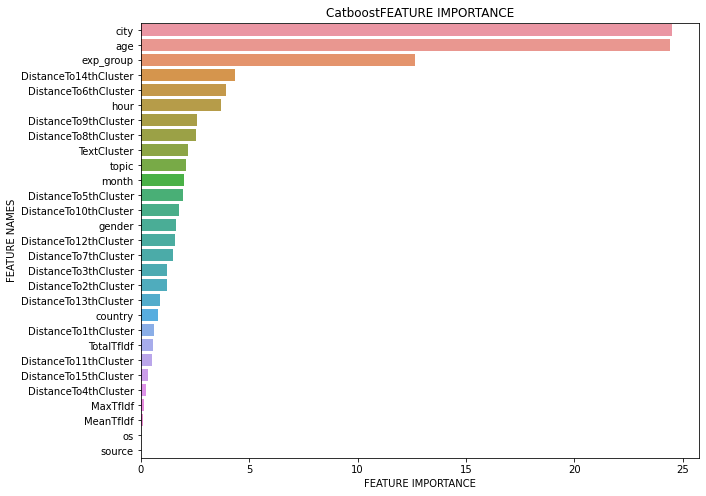

In [27]:
### Из любопытства посмотрим на feature_importance

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(catboost.feature_importances_,X_train.columns,'Catboost')

In [28]:
### Сохраним модель

catboost.save_model(
    'catboost_model',
    format="cbm"                  
)

### Положим в базу фичи, необходимые для функционала нашей модели

In [29]:
posts_info.to_sql(    
   "posts_info_features",                    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml",                      
    schema="public",                   
    if_exists='replace'            
   )                               
                                   

In [30]:
### Все ли норм?

test_ = pd.read_sql(
    """SELECT * FROM public.posts_info_features""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

test_

,index,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190,9,0.475002,0.445159,...,0.467069,0.439683,0.533231,0.500861,0.228399,0.460128,0.541393,0.527870,0.482178,0.465407
1,1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258,2,0.339988,0.302661,...,0.335358,0.282634,0.270872,0.365750,0.224602,0.304849,0.435787,0.412782,0.344635,0.326576
2,2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276,9,0.375452,0.330985,...,0.349554,0.314282,0.478035,0.397052,0.092221,0.352706,0.477009,0.434594,0.367229,0.356885
3,3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144,9,0.333294,0.296091,...,0.308285,0.259554,0.429315,0.323492,0.143065,0.295811,0.440611,0.388099,0.324818,0.298267
4,4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138,2,0.312445,0.231881,...,0.246607,0.170158,0.393902,0.297860,0.224006,0.252199,0.396040,0.344683,0.266365,0.232839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7017,7314,Although the likeliness of someone focusing on...,movie,10.326422,0.300231,0.000224,4,0.539595,0.476533,...,0.345142,0.395804,0.579179,0.537647,0.517702,0.513243,0.573436,0.562366,0.420976,0.499711
7019,7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,6.703302,0.258412,0.000146,4,0.438798,0.353380,...,0.169225,0.262581,0.494768,0.426395,0.413551,0.409010,0.489136,0.448070,0.320816,0.372106
7020,7020,7317,I cant believe this film was allowed to be mad...,movie,5.628524,0.573061,0.000122,13,0.378814,0.289811,...,0.197431,0.163497,0.454329,0.342170,0.346480,0.342714,0.394556,0.379629,0.070661,0.281480
7021,7021,7318,The version I saw of this film was the Blockbu...,movie,6.883375,0.231244,0.000150,5,0.392630,0.302369,...,0.166371,0.201546,0.449223,0.381538,0.351853,0.354652,0.360774,0.410414,0.172194,0.323347
